In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization

from keras.callbacks import ReduceLROnPlateau

In [3]:
from tensorflow.keras.optimizers import RMSprop,Adam

In [4]:
import tensorflow as tf
from keras import optimizers 

In [5]:
train=pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test=pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [6]:
train_label=train['label']
train_data=train.drop('label', axis=1)

In [7]:
train_data.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [8]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [9]:
train_data=train_data /255


In [10]:

train_data=train_data.values.reshape(-1,28,28,1)


In [11]:
train_label = to_categorical(train_label, num_classes = 10)

In [12]:
X_train,X_test,y_train,y_test=train_test_split(train_data,train_label,random_state=42,test_size=0.15)

MODEL

In [13]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [14]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization(momentum=.15))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization(momentum=0.15))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization(momentum=.15))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(10, activation = "softmax"))

2022-08-09 14:40:49.667878: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        3

In [16]:
optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)

In [17]:
model.compile(optimizer=optimizer,loss=['categorical_crossentropy'],metrics=['accuracy'])


In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [19]:
epochs=5 #change this to 30 if you need to get better score
batch_size=64

In [20]:
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,y_test),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-08-09 14:40:50.481504: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
557/557 - 81s - loss: 0.4533 - accuracy: 0.8557 - val_loss: 0.0645 - val_accuracy: 0.9792
Epoch 2/5
557/557 - 80s - loss: 0.1177 - accuracy: 0.9636 - val_loss: 0.0507 - val_accuracy: 0.9837
Epoch 3/5
557/557 - 80s - loss: 0.0910 - accuracy: 0.9723 - val_loss: 0.0439 - val_accuracy: 0.9860
Epoch 4/5
557/557 - 80s - loss: 0.0750 - accuracy: 0.9775 - val_loss: 0.0409 - val_accuracy: 0.9883
Epoch 5/5
557/557 - 80s - loss: 0.0647 - accuracy: 0.9820 - val_loss: 0.0285 - val_accuracy: 0.9919


In [21]:
y_pre_test=model.predict(X_test)
y_pre_test=np.argmax(y_pre_test,axis=1)
y_test=np.argmax(y_test,axis=1)

In [22]:
conf=confusion_matrix(y_test,y_pre_test)
conf=pd.DataFrame(conf,index=range(0,10),columns=range(0,10))
conf

,0,1,2,3,4,5,6,7,8,9
0,598,0,0,0,0,0,2,0,0,0
1,0,675,1,0,0,0,1,3,0,0
2,0,0,646,0,0,0,0,0,0,0
3,0,0,3,714,0,0,0,1,0,1
4,0,0,0,0,625,0,0,0,0,4
5,0,0,0,3,0,510,2,0,1,0
6,0,1,0,0,1,0,596,0,0,0
7,0,1,7,0,0,0,0,658,0,1
8,0,0,6,1,1,0,0,1,605,2
9,0,0,3,0,1,1,0,2,0,622


<AxesSubplot:>

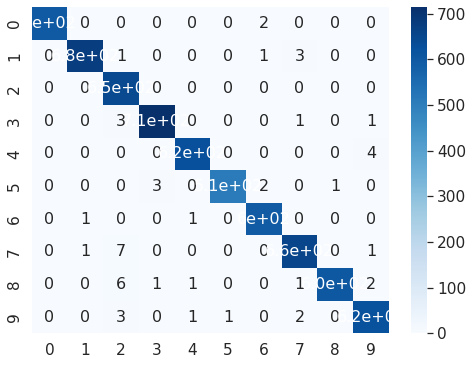

In [23]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf, annot=True,annot_kws={"size": 16},cmap=plt.cm.Blues)# font size

In [24]:
#test_id=test.id

#test=test.drop('id',axis=1)
test=test/255
test=test.values.reshape(-1,28,28,1)

In [25]:
y_pre=model.predict(test)     ##making prediction
y_pre=np.argmax(y_pre,axis=1) ##changing the prediction intro labels

In [26]:
sample_sub=pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")

In [27]:
sample_sub['label']=y_pre
sample_sub.to_csv('submission.csv',index=False)

In [28]:
sample_sub.head()

,ImageId,Label,label
0,1,0,2
1,2,0,0
2,3,0,9
3,4,0,0
4,5,0,3


In [29]:
model.save("keras_mnist1.h5")

In [30]:
# install / update the tensorflowjs package
!pip install tensorflowjs > /dev/null 2>&1

import tensorflowjs
print(tensorflowjs.__version__)

# convert keras model to tensorflow js


3.19.0


In [31]:
tensorflowjs.converters.save_keras_model(model, '/kaggle/working')